# Setup
## Goal

Do the numerically calculated energy levels match the associated hermite polynomial for a quantum harmonic oscillator?

## Imports

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy
import seaborn as sns
import torch

## Setup CUDA usage

In [2]:
# https://github.com/pytorch/tutorials/issues/3263#issue-2811049983

device_name = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")
    # device_name = torch.cpu ... # TODO: Find the cpu device name

torch.set_default_device(device)
print(f"Using {device} device: {device_name}")

Using cuda device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Global settings

In [3]:
n_time_intervals: int = 20
number_of_energy_levels: int = 30
omega: float = 10.
resolution: int = 10000#
target_energy_level: int = 9
time_delta: float = 1.
total_evolution_time: float = time_delta * n_time_intervals
x_max: float = 10.
x_min: float = -10.
# Hilbert space
valid_x = torch.linspace(x_min, x_max, resolution)
delta_x = valid_x[1] - valid_x[0]

## Potential

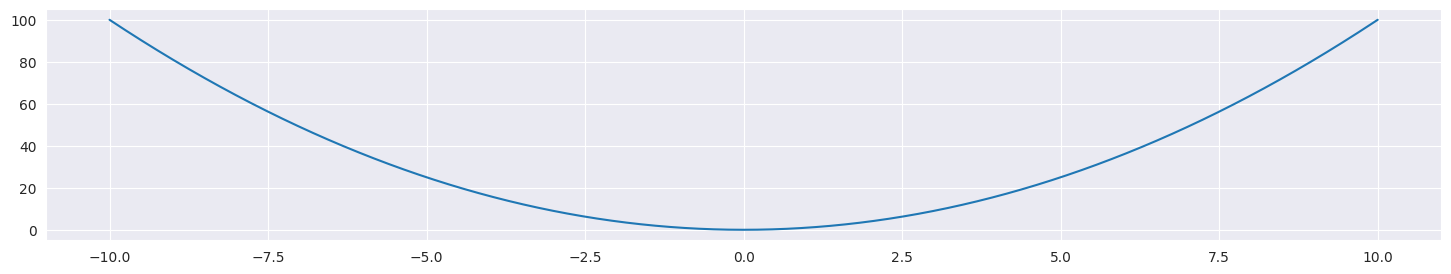

In [4]:
def potential(x):
    return x ** 2



plt.figure(figsize=(18, 3))
plt.plot(valid_x.cpu(), potential(valid_x.cpu()))


## Hamiltonian

In [5]:
def generate_hamiltonian(omega: torch.Tensor | float, center: torch.Tensor | float = torch.tensor(0)) -> torch.Tensor:
    return 2 * torch.diag(torch.ones(resolution)) / delta_x ** 2 \
        - ((torch.diag(torch.ones(resolution - 1), diagonal=1) + torch.diag(torch.ones(resolution - 1),
                                                                            diagonal=-1)) / delta_x ** 2) \
        + torch.diag(torch.tensor([.5 * (omega * x) ** 2 for x in valid_x]))


hamiltonian = generate_hamiltonian(omega=omega)

## Analytical Solution

In [6]:
def analytical_solution(
        energy_level: int,
        omega: torch.Tensor | float,
        mass: torch.Tensor | float = 1,

) -> np.array:
    # https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator#Hamiltonian_and_energy_eigenstates
    temp_val = [
        np.exp(-1 * np.divide(mass * omega * x**2, 2))*scipy.special.hermite(energy_level)(np.sqrt(mass * omega)*x)
        for x
        in valid_x.cpu().numpy()
    ]
    temp_val/=np.linalg.norm(temp_val)
    return temp_val

## Energy levels

In [ ]:
eigenvalues, eigenvectors = torch.linalg.eigh(hamiltonian)
eigenvalues = eigenvalues[:number_of_energy_levels]
eigenvectors = torch.transpose(eigenvectors, dim0=0, dim1=1)[:number_of_energy_levels]

fig, axes = plt.subplots(number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(number_of_energy_levels)
fig.set_figwidth(18)

for i, (val, vector) in tqdm(enumerate(zip(eigenvalues, eigenvectors)), total=number_of_energy_levels):
    # normalized_vector = vector.cpu().numpy()/np.sum()
    axes[i].plot(
        valid_x.cpu().numpy(),
        np.real(vector.cpu().numpy()),
        label=f"Numerical, $\\| \\psi \\|_2 = {np.linalg.norm(np.real(vector.cpu().numpy())):.2f}$"
    )
    # axes[i].plot(
    #     valid_x.cpu().numpy(),
    #     np.imag(vector.cpu().numpy())/sum(np.real(vector.cpu().numpy())),
    #     label=f"Imag {sum(np.imag(vector.cpu().numpy())):.2f}"
    # )
    # axes[i].plot(valid_x.cpu().numpy(), np.imag(vector.cpu().numpy()), label=f"Imag")
    solution = analytical_solution(i, omega=omega)
    if np.dot(solution, np.real(vector.cpu().numpy())) < 0:
        solution *= -1
    axes[i].plot(
        valid_x.cpu().numpy(),
        solution,
        label=f"Analytical, $\\| \\psi \\|_2 =  {np.linalg.norm(analytical_solution(i, omega=omega)):.2f}$"
    )
    axes[i].plot([], [], label=f"E={np.real(val):.3f}")
    axes[i].legend(loc='right')

plt.show()


 33%|███▎      | 10/30 [00:25<00:58,  2.93s/it]

## Orthonormality check

<Axes: >

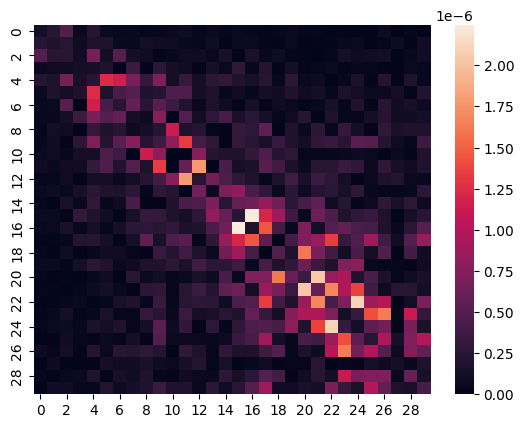

In [35]:
# Ideally this should all be zeroes
error_matrix = torch.abs(eigenvectors @ torch.transpose(eigenvectors, dim0=0, dim1=1)) - torch.eye(
    number_of_energy_levels)
sns.heatmap(np.abs(error_matrix.cpu().numpy()))

In [36]:
np.polynomial.hermite.hermx

array([0. , 0.5])